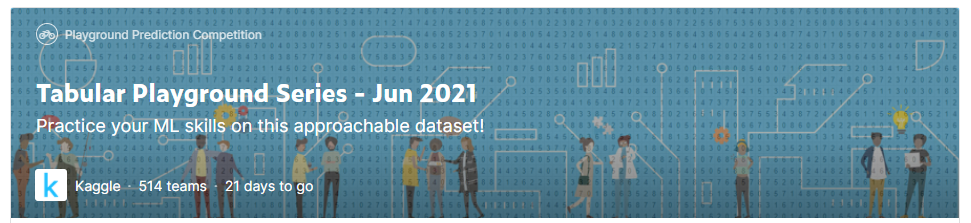

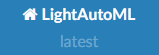

Googleによれば、AutoMLの基本的なコンセプトは、高度なプログラミングの能力を必要とせず、誰でも画像をアップロードするとGoogleのシステムが自動的に機械学習モデルを作成してくれるというものだ。
AutoML（Automated Machine Learning：自動化された機械学習）とは、機械学習モデルの設計・構築を自動化するための手法全般、またはその概念を指す。

　特にグーグルは「AutoML」を標榜して各種AIサービスへの搭載に注力しており、初出では2017年5月に「Google AI Blog: Using Machine Learning to Explore Neural Network Architecture」という記事を公開している。現時点では、GCP（Google Cloud Platform）の「Cloud AutoML」（執筆時点でベータ版）で、「AutoML Vision」などの転移学習系のサービスや、「AutoML Tables」などの機械学習モデルを自動選択するサービスが既に提供されている。有償だけどこのサービスを使えばkaggleは楽勝のようなことが書いてあった。本当ですかね。

In [ ]:
pip install -U lightautoml # -U 

#インポート 

In [ ]:
# Standard python libraries
import os
import time
import re

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

# Imports 
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.dataset.roles import NumericRole

# パラメータ

In [ ]:
N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 8 * 3600 # Time in seconds for automl run
TARGET_NAME = 'target'

データロード

In [ ]:
%%time

train_data = pd.read_csv('../input/tabular-playground-series-jun-2021/train.csv')
train_data[TARGET_NAME] = train_data[TARGET_NAME].str.slice(start=6).astype(int) - 1
train_data.head()

このtargetとsubmissionのクラスとの関係はどうするの？

In [ ]:
test_data = pd.read_csv('../input/tabular-playground-series-jun-2021/test.csv')
test_data.head()

In [ ]:
submission = pd.read_csv('../input/tabular-playground-series-jun-2021/sample_submission.csv')
submission.head()

## タスク作成

マルチクラス分類なので、multicalssを設定

In [ ]:
%%time

task = Task('multiclass',)

## カラム設定

In [ ]:
%%time

roles = {
    'target': TARGET_NAME,
    'drop': ['id'],
}

## トレイニング

３つのアルゴリズムでトレイニングする。結果も３つ出力される。

In [ ]:
%%time 

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       general_params = {
                           'use_algos': [['linear_l2', 'lgb_tuned', 'cb_tuned']], #linear_l2', 'lgb', 'lgb_tuned'というパターンもできるみたい
                           'return_all_predictions': True,
                           'weighted_blender_max_nonzero_coef': 0.0
                       },
                       tuning_params = {'max_tuning_time': 1800},
                       reader_params = {'n_jobs': N_THREADS},
                       config_path = '../input/lightautoml-configs/conf_0_sel_type_0.yml'
                       )
oof_pred = automl.fit_predict(train_data, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred[:10], oof_pred.shape))

In [ ]:
!cat config_path

予測

In [ ]:
%%time

test_pred = automl.predict(test_data)
print('Prediction for test data:\n{}\nShape = {}'.format(test_pred[:10], test_pred.shape))

# print('Check scores...')
# print('OOF score: {}'.format(log_loss(train_data[TARGET_NAME].values, oof_pred.data)))

## すべての OF とテスト pred をトレーニング データとテスト データに組み合わせる

In [ ]:
columns = ['PREDS_Linear_' + str(i) for i in range(1, 10)] + \
          ['PREDS_LGBM_' + str(i) for i in range(1, 10)] + \
          ['PREDS_CB_' + str(i) for i in range(1, 10)] + \
          ['PREDS_NN_' + str(i) for i in range(1, 10)]
columns

これやられちゃうとわからない。このデータは一体どうやって作ったのか。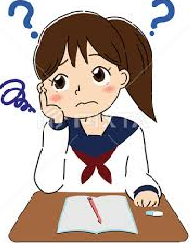

In [ ]:
oof_nn = pd.read_csv('../input/python-keras-nn-residual/OOF_nn_predict.csv')
test_nn = pd.read_csv('../input/python-keras-nn-residual/nn_predict.csv')
oof_nn

In [ ]:
OOF_preds = pd.DataFrame(np.hstack((oof_pred.data, oof_nn.drop('id', axis = 1))), columns = columns)
TEST_preds = pd.DataFrame(np.hstack((test_pred.data, test_nn.drop('id', axis = 1))), columns = columns)

In [ ]:
for col in columns:
    train_data[col] = OOF_preds[col]
    test_data[col] = TEST_preds[col]

In [ ]:
test_data.head()

##  preds を使用してデータセットで LightAutoML モデルをトレーニングする

In [ ]:
%%time 

roles = {
    'target': TARGET_NAME,  #ここでターゲットを設定
    'drop': ['id'],         #traingdataの不要なものを削除
    NumericRole(np.float32, prob = True): columns    #トレーニングするデータのカラムを指定する。
}

automl = TabularUtilizedAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       general_params = {
                           'use_algos': [['lgb_tuned', 'cb_tuned']], #あれ２種類
                       },
                       tuning_params = {'max_tuning_time': 1800},
                       reader_params = {'n_jobs': N_THREADS},
                       configs_list = ['../input/lightautoml-configs/conf_1_sel_type_1.yml'],
                       max_runs_per_config=1
                       )
oof_pred = automl.fit_predict(train_data, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred[:10], oof_pred.shape))

In [ ]:
# 特徴の重要度の計算
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

テストデータの予測とスコアのチェック

In [ ]:
test_pred = automl.predict(test_data)
print('Prediction for test data:\n{}\nShape = {}'.format(test_pred[:10], test_pred.shape))

print('Check scores...')
print('OOF score: {}'.format(log_loss(train_data[TARGET_NAME].values, oof_pred.data)))

## サブミッション

In [ ]:
submission.iloc[:, 1:] = test_pred.data
submission.to_csv('sample.csv', index = False)

In [ ]:
submission